# Exploring Dandiset 000617: Allen Institute Openscope - Sequence Learning Project

**Important Note:** This notebook was primarily AI-generated and has not been fully verified by human experts. Please exercise caution when interpreting the code or results, and verify critical findings independently.

## Overview of the Dandiset

This notebook explores Dandiset [000617](https://dandiarchive.org/dandiset/000617/0.250312.0130) version `0.250312.0130`, titled "Allen Institute Openscope - Sequence Learning Project".

**Description from DANDI:**
> Adaptive and coordinated behavior requires that an animal be able to make predictions about the near and even far future. This intuition that some neural computations should be ‘predictive’ in their character has a long history... Our experimental design is based on a Sequence Learning Experiment, in which head-fixed mice passively view sequences of three different natural movie clips (labeled ‘A’, ‘B’, ‘C’)... Our design uses 2-photon microscopy with eight simultaneously recorded fields-of-view. The fields-of-view will include both layer 2/3 and layer 4 as well as from multiple cortical areas: V1 (VISp), LM (VISl), AM (VISam), and PM (VISpm). The experiment used the Cux2-CreERTS2:Camk2a-tTa; Ai93(TITL-GCaMP6f) mouse line, which has expression in excitatory neurons of both layer 4 and 2/3.

**Citation:**
> Berry, Michael; Lecoq, Jérôme; Amaya, Avalon; Wilkes, Josh; Nguyen, Katrina; Peene, Carter; Bawany, Ahad; Han, Warren Han; Seid,  Samuel; Young, Ahrial; Naidoo, Robyn; Ha, Vivian; Johnson, Tye; Williford, Ali; Swapp, Jackie; Caldejon, Shiella (2025) Allen Institute Openscope - Sequence Learning Project (Version 0.250312.0130) [Data set]. DANDI Archive. https://doi.org/10.48324/dandi.000617/0.250312.0130

This notebook will cover:
* How to list basic information about the Dandiset using the DANDI API.
* How to load a specific NWB (Neurodata Without Borders) file from this Dandiset.
* How to access and visualize some of the ophys (optical physiology) data within the NWB file, specifically:
    * Delta F over F (dF/F) fluorescence traces for selected Regions of Interest (ROIs).
    * Image masks for these ROIs to understand their spatial layout.
* Pointers for further exploration.

## Required Packages

To run this notebook, you will need the following Python packages installed:
* `dandi` (for interacting with the DANDI Archive)
* `pynwb` (for working with NWB files)
* `h5py` (dependency for pynwb for HDF5 file access)
* `remfile` (for streaming remote files)
* `numpy` (for numerical operations)
* `matplotlib` (for plotting)
* `pandas` (for tabular data handling, used here to introspect ROI tables)
* `seaborn` (for enhanced plot styling)

This notebook assumes these packages are already installed in your Python environment.

## Listing Dandiset Information with DANDI API

In [1]:
from itertools import islice
from dandi.dandiapi import DandiAPIClient

# Connect to DANDI archive
client = DandiAPIClient()
dandiset_id = "000617"
dandiset_version = "0.250312.0130" # Draft version at time of notebook creation
dandiset = client.get_dandiset(dandiset_id, dandiset_version)

# Print basic information about the Dandiset
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata.get('name', 'N/A')}")
print(f"Dandiset URL: {metadata.get('url', 'N/A')}")
print(f"Dandiset description snippet: {metadata.get('description', 'N/A')[:200]}...")

# List some assets in the Dandiset
print("\nFirst 5 assets in this Dandiset version:")
for asset_count, asset in enumerate(islice(dandiset.get_assets(), 5)):
    print(f"- Path: {asset.path} (ID: {asset.identifier}, Size: {asset.size} bytes)")
    if asset_count == 0: # Store the first asset_id for later use if needed, though we'll hardcode one.
        first_asset_id_example = asset.identifier

Dandiset name: Allen Institute Openscope - Sequence Learning Project
Dandiset URL: https://dandiarchive.org/dandiset/000617/0.250312.0130
Dandiset description snippet: Adaptive and coordinated behavior requires that an animal be able to make predictions about the near and even far future. This intuition that some neural computations should be ‘predictive’ in their c...

First 5 assets in this Dandiset version:
- Path: sub-684475/sub-684475_ses-1294084428-acq-1294179945-raw-movies_ophys.nwb (ID: 3eaf1acf-7a63-4286-a7c0-7a58d8cae2f8, Size: 21166274512 bytes)
- Path: sub-684475/sub-684475_ses-1294084428-acq-1294179943-raw-movies_ophys.nwb (ID: 4cfa15bb-eac7-4273-9141-6d0cc2034506, Size: 21161416822 bytes)
- Path: sub-684475/sub-684475_ses-1293785946-acq-1293914859-raw-movies_ophys.nwb (ID: d0b9a557-2c98-4fbc-af96-2318e6e5f2eb, Size: 21174751013 bytes)
- Path: sub-684475/sub-684475_ses-1294084428-acq-1294179942-raw-movies_ophys.nwb (ID: 6b8f9ba6-2481-4c7b-b78c-38c2b878d246, Size: 211576748

## Loading a Specific NWB File

We will now load a specific NWB file from the Dandiset. For this demonstration, we'll use the file:
`sub-677038/sub-677038_ses-1280089433-acq-1280384858_ophys.nwb`

Its asset ID is `27dd7936-b3e7-45af-aca0-dc98b5954d19`.
The direct download URL for this asset is:
`https://api.dandiarchive.org/api/assets/27dd7936-b3e7-45af-aca0-dc98b5954d19/download/`

We will use `pynwb`, `h5py`, and `remfile` to stream and read this remote NWB file.

In [2]:
import pynwb
import h5py
import remfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# URL of the NWB file we want to load
nwb_file_url = "https://api.dandiarchive.org/api/assets/27dd7936-b3e7-45af-aca0-dc98b5954d19/download/"
asset_id = "27dd7936-b3e7-45af-aca0-dc98b5954d19" # For Neurosift link

print(f"Attempting to load NWB file from: {nwb_file_url}")

# Use remfile to allow streaming access to the remote HDF5 file
remote_f = remfile.File(nwb_file_url)
h5_f = h5py.File(remote_f, 'r')

# Open the NWB file using PyNWB
# Note: It's good practice to close the IO object, but for brevity in notebooks,
# this is often omitted. For long-running scripts, use a `with` statement.
io = pynwb.NWBHDF5IO(file=h5_f, mode='r', load_namespaces=True)
nwbfile = io.read()

print("\nSuccessfully loaded NWB file.")
print(f"Session ID: {nwbfile.session_id}")
print(f"Identifier: {nwbfile.identifier}")
print(f"Session Description: {nwbfile.session_description}")
print(f"Session Start Time: {nwbfile.session_start_time}")
print(f"Institution: {nwbfile.institution}")
print(f"Lab: {nwbfile.lab}")

Attempting to load NWB file from: https://api.dandiarchive.org/api/assets/27dd7936-b3e7-45af-aca0-dc98b5954d19/download/



Successfully loaded NWB file.
Session ID: None
Identifier: 1280384858
Session Description: Ophys Session
Session Start Time: 2023-06-30 16:04:51.055000+00:00
Institution: Allen Institute for Brain Science
Lab: None


## Structure of the NWB File

NWB files have a hierarchical structure. Key data groups relevant to ophys experiments often include:
*   `acquisition`: Raw acquired signals (e.g., voltage signals from behavior tracking).
*   `processing`: Processed data. For ophys, this is where you'll find modules like:
    *   `ophys`: Contains data interfaces for fluorescence traces, dF/F, event detection, image segmentation etc.
        *   `dff (DfOverF)`: Contains ROI response series for dF/F traces.
        *   `corrected_fluorescence (Fluorescence)`: Contains ROI response series for corrected fluorescence traces.
        *   `event_detection (OphysEventDetection)`: Contains detected neural events.
        *   `image_segmentation (ImageSegmentation)`: Contains plane segmentations defining ROIs, including their image masks and metadata.
*   `stimulus`: Information about stimuli presented.
*   `intervals`: Time intervals for various experimental epochs or behaviors.

You can explore the NWB file structure by printing `nwbfile` or accessing its attributes like `nwbfile.processing['ophys']`.

For a detailed, interactive view of this NWB file's structure and data, you can use Neurosift:
[Explore this NWB file on Neurosift](https://neurosift.app/nwb?url={nwb_file_url}&dandisetId={dandiset_id}&dandisetVersion={dandiset_version})
(Neurosift link: `https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/27dd7936-b3e7-45af-aca0-dc98b5954d19/download/&dandisetId=000617&dandisetVersion=0.250312.0130`)

In [3]:
# Example: Print available processing modules
print("Available processing modules:", list(nwbfile.processing.keys()))
if 'ophys' in nwbfile.processing:
    print("Ophys module contains:", list(nwbfile.processing['ophys'].data_interfaces.keys()))

Available processing modules: ['ophys', 'running', 'stimulus', 'stimulus_ophys']
Ophys module contains: ['corrected_fluorescence', 'dff', 'event_detection', 'image_segmentation', 'images', 'neuropil_trace', 'ophys_motion_correction_x', 'ophys_motion_correction_y']


## Visualizing dF/F Traces

Delta F over F (dF/F) is a common measure of neural activity from calcium imaging, representing the change in fluorescence relative to a baseline.
We will plot the dF/F traces for a few selected Regions of Interest (ROIs).

The Allen Brain Observatory dataset often marks ROIs as "valid" based on quality control. We will try to select valid ROIs. The `cell_specimen_id` is an identifier for ROIs; if it's -1, it often indicates an ROI that may not correspond to a cell or failed some QC, but the `valid_roi` flag is more direct.

dF/F data shape: (40019, 121) (timepoints, ROIs)
Number of ROIs in table: 121
Plotting the first 3 'valid' ROIs based on their order in the table.


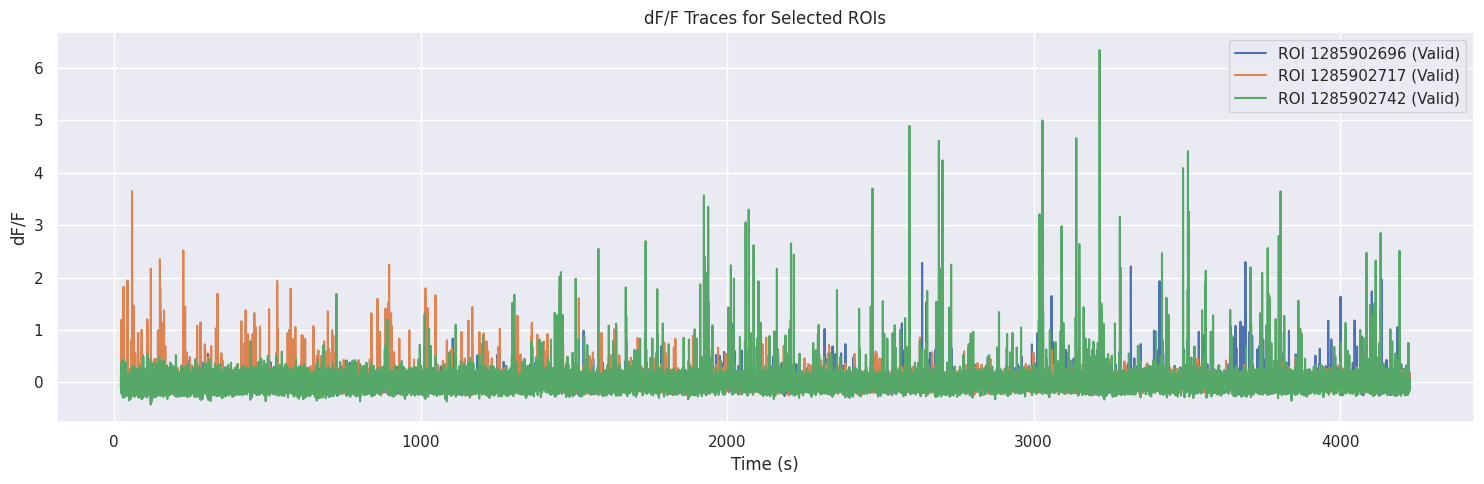


Details for plotted ROIs (using original ID labels from table):
            cell_specimen_id  valid_roi    x   y  width  height
id                                                             
1285902696                -1       True   47  47     23      22
1285902717                -1       True  282  32     18      18
1285902742                -1       True  420  35     21      19


In [4]:
# Access the dF/F data
if 'ophys' in nwbfile.processing and 'dff' in nwbfile.processing['ophys'].data_interfaces:
    dff_interface = nwbfile.processing['ophys']['dff']
    # dF/F traces are usually under a 'RoiResponseSeries' named 'traces' or similar
    if 'traces' in dff_interface.roi_response_series:
        dff_traces_rs = dff_interface.roi_response_series['traces']
        
        timestamps = dff_traces_rs.timestamps[:]  # Time points for the traces
        all_dff_data = dff_traces_rs.data[:]      # dF/F data (num_timepoints x num_rois)
        
        # Get the ROI table which contains metadata for each ROI
        roi_table = dff_traces_rs.rois.table
        roi_table_df = roi_table.to_dataframe()
        
        print(f"dF/F data shape: {all_dff_data.shape} (timepoints, ROIs)")
        print(f"Number of ROIs in table: {len(roi_table_df)}")
        # print("\nFirst few rows of ROI table:")
        # print(roi_table_df[['cell_specimen_id', 'valid_roi', 'x', 'y', 'width', 'height']].head())

        # Select ROIs to plot (e.g., first 3 valid ones)
        valid_roi_mask_bool = roi_table_df['valid_roi'].to_numpy(dtype=bool)
        valid_roi_positional_indices = np.where(valid_roi_mask_bool)[0].tolist()
        
        num_rois_to_plot = 3
        final_selected_positional_indices = []

        if len(valid_roi_positional_indices) >= num_rois_to_plot:
            print(f"Plotting the first {num_rois_to_plot} 'valid' ROIs based on their order in the table.")
            final_selected_positional_indices = valid_roi_positional_indices[:num_rois_to_plot]
        elif len(valid_roi_positional_indices) > 0:
            print(f"Fewer than {num_rois_to_plot} 'valid' ROIs found. Plotting all {len(valid_roi_positional_indices)} 'valid' ROIs.")
            final_selected_positional_indices = valid_roi_positional_indices
        else:
            print(f"No 'valid' ROIs found. Plotting the first up to {num_rois_to_plot} ROIs by positional index (may not be actual cells).")
            num_available_rois = all_dff_data.shape[1]
            final_selected_positional_indices = list(range(min(num_rois_to_plot, num_available_rois)))

        if not final_selected_positional_indices and all_dff_data.shape[1] > 0:
             print(f"No specific ROIs selected by criteria, but data exists. Defaulting to first ROI if available.")
             if all_dff_data.shape[1] > 0:
                final_selected_positional_indices = [0] 
        
        if final_selected_positional_indices:
            rois_data_to_plot = all_dff_data[:, final_selected_positional_indices]
            
            # Get original ID labels for plotted ROIs for metadata
            final_selected_id_labels = roi_table_df.index[final_selected_positional_indices].tolist()

            roi_plot_labels = []
            for pos_idx, id_label in zip(final_selected_positional_indices, final_selected_id_labels):
                cell_id = roi_table_df.loc[id_label, 'cell_specimen_id']
                is_valid = roi_table_df.loc[id_label, 'valid_roi']
                # Use cell_id if not -1, otherwise use the table's main ID (like 1285902696)
                display_id = cell_id if str(cell_id) != '-1' else id_label 
                label_str = f"ROI {display_id}"
                if 'valid_roi' in roi_table_df.columns: # Add validity info if column exists
                    label_str += f" ({'Valid' if is_valid else 'Not Valid'})"
                roi_plot_labels.append(label_str)

            # Create the plot
            sns.set_theme()
            plt.figure(figsize=(15, 5))
            if rois_data_to_plot.ndim == 1: # Single ROI selected
                 plt.plot(timestamps, rois_data_to_plot, label=roi_plot_labels[0])
            else: # Multiple ROIs
                for i in range(rois_data_to_plot.shape[1]):
                    plt.plot(timestamps, rois_data_to_plot[:, i], label=roi_plot_labels[i])
            
            plt.xlabel('Time (s)')
            plt.ylabel('dF/F')
            plt.title(f'dF/F Traces for Selected ROIs')
            plt.legend(loc='upper right')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            
            print("\nDetails for plotted ROIs (using original ID labels from table):")
            print(roi_table_df.loc[final_selected_id_labels, ['cell_specimen_id', 'valid_roi', 'x', 'y', 'width', 'height']])
        else:
            print("No ROIs were selected for plotting dF/F traces.")
            
    else:
        print("dF/F data or 'traces' RoiResponseSeries not found in the expected location.")
else:
    print("Ophys processing module not found in this NWB file.")

## Visualizing ROI Masks

The `image_mask` for each ROI defines which pixels in the imaging plane belong to that ROI. Let's visualize the masks for the same ROIs we plotted dF/F traces for. These are often stored as 2D arrays (boolean or integer) that match the dimensions of the imaging plane.

Plotting image masks for 3 ROIs previously selected for dF/F traces.
Assuming all masks are 512x512 like the first one.


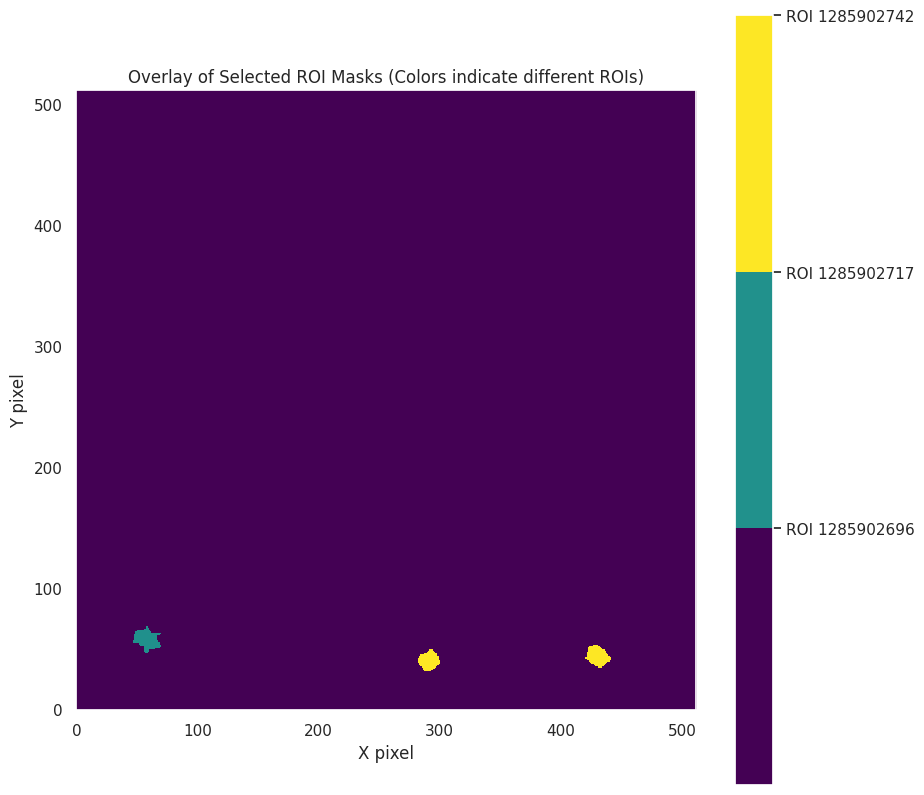

In [5]:
# Visualize ROI masks for the ROIs selected in the previous cell
if 'ophys' in nwbfile.processing and \
   'image_segmentation' in nwbfile.processing['ophys'].data_interfaces and \
   len(nwbfile.processing['ophys']['image_segmentation'].plane_segmentations) > 0:

    # Typically, ROI info (including masks) is linked from the RoiResponseSeries' .rois.table
    # or directly from a PlaneSegmentation table in ImageSegmentation.
    # We'll use the same roi_table_df derived from dff_traces_rs.rois.table.
    # Ensure `final_selected_id_labels` and `final_selected_positional_indices` are available from the dF/F cell.
    # This cell implicitly depends on the previous cell's `final_selected_id_labels`.
    
    if 'final_selected_id_labels' in locals() and final_selected_id_labels:
        print(f"Plotting image masks for {len(final_selected_id_labels)} ROIs previously selected for dF/F traces.")
        
        # Determine canvas size from the first mask (assuming all are consistent full-plane masks)
        first_mask_shape = roi_table_df.loc[final_selected_id_labels[0], 'image_mask'].shape
        canvas_height, canvas_width = first_mask_shape
        print(f"Assuming all masks are {canvas_height}x{canvas_width} like the first one.")

        overlay_image = np.zeros((canvas_height, canvas_width), dtype=float)
        roi_details_for_mask_plot = [] # for colorbar labels

        for i, id_label in enumerate(final_selected_id_labels):
            roi_data_series = roi_table_df.loc[id_label]
            mask = roi_data_series['image_mask']

            if mask.shape == (canvas_height, canvas_width):
                overlay_image = np.maximum(overlay_image, mask.astype(float) * (i + 1))
            else:
                print(f"Warning: ROI {id_label} mask shape {mask.shape} differs from canvas {canvas_height}x{canvas_width}. Skipping for overlay.")
                continue
            
            roi_x_tl = int(roi_data_series['x'])
            roi_y_tl = int(roi_data_series['y'])
            roi_w = int(roi_data_series['width'])
            roi_h = int(roi_data_series['height'])
            cell_id = roi_data_series['cell_specimen_id']
            is_valid = roi_data_series['valid_roi']
            display_id = cell_id if str(cell_id) != '-1' else id_label
            label_text = f"ROI {display_id}" # Keep it concise for colorbar
            roi_details_for_mask_plot.append({'label': label_text, 'color_val': i + 1})

        plt.figure(figsize=(10, 10))
        if np.max(overlay_image) > 0:
            num_colors = len(roi_details_for_mask_plot) # Number of ROIs actually added to overlay
            cmap = plt.get_cmap('viridis', num_colors) if num_colors > 0 else plt.get_cmap('viridis')
            plt.imshow(overlay_image, cmap=cmap, interpolation='nearest', origin='lower') # 'lower' for matrix convention
            
            if num_colors > 0:
                colorbar_ticks = np.arange(1, num_colors + 1)
                cbar = plt.colorbar(ticks=colorbar_ticks)
                cbar_labels = [detail['label'] for detail in roi_details_for_mask_plot]
                cbar.ax.set_yticklabels(cbar_labels)
        else:
            plt.text(0.5, 0.5, "No mask data to display or masks were skipped.", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

        plt.title(f'Overlay of Selected ROI Masks (Colors indicate different ROIs)')
        plt.xlabel('X pixel')
        plt.ylabel('Y pixel')
        # plt.gca().invert_yaxis() # Common for images if origin is top-left; NWB might be 'lower' by default for imshow
        plt.grid(False)
        plt.show()
    else:
        print("No ROIs selected from the dF/F plotting cell, or 'final_selected_id_labels' not found.")
else:
    print("Ophys module, ImageSegmentation, or PlaneSegmentation not found as expected.")

## Summary and Future Directions

This notebook demonstrated how to:
*   Connect to the DANDI archive and retrieve basic information about a Dandiset.
*   Load a specific NWB ophys file by streaming it from the archive.
*   Access and interpret some key metadata from the NWB file.
*   Extract and plot dF/F calcium imaging traces for selected ROIs.
*   Visualize the spatial masks of these ROIs.

**Future Directions for Analysis:**
*   **Correlate neural activity with stimulus presentation:** The NWB file contains stimulus presentation times (e.g., `nwbfile.stimulus_template` or `nwbfile.intervals`). One could align the dF/F traces to the onset of different stimuli (movie clips A, B, C, or gray screen) to analyze stimulus-evoked responses.
*   **Analyze running speed:** The file contains running speed data (e.g., `nwbfile.processing['running']['speed']`). This could be correlated with neural activity.
*   **Explore event data:** If `OphysEventDetection` data is present and reliable, one could analyze the timing and rate of detected neural events.
*   **Compare responses across different experimental conditions or days:** This Dandiset involves sequence learning over multiple days. Comparing ROI activity across different sessions (different NWB files for the same subject/area) could reveal learning-related changes.
*   **Population analysis:** Instead of looking at individual ROIs, one could perform dimensionality reduction (e.g., PCA) on the activity of many ROIs to find dominant patterns of population activity.
*   **Further ROI properties:** The ROI table contains more metadata for each ROI (e.g., location, depth if available across multiple planes, etc.) that could be used to group or filter ROIs for analysis.

Remember that this is just a starting point. The richness of NWB files and the DANDI archive allows for a wide range of neuroscientific explorations.

---
Notebook generation complete.

In [6]:
# Close the HDF5 file and the PyNWB IO object
# This is important for proper resource management, especially with remote files.
if 'io' in locals() and io is not None:
    try:
        io.close()
        print("PyNWB IO object closed.")
    except Exception as e:
        print(f"Error closing PyNWB IO object: {e}")

if 'h5_f' in locals() and h5_f is not None:
    try:
        h5_f.close()
        print("HDF5 file object closed.")
    except Exception as e:
        print(f"Error closing HDF5 file object: {e}")

if 'remote_f' in locals() and remote_f is not None:
    try:
        remote_f.close() # remfile object
        print("remfile object closed.")
    except Exception as e:
        print(f"Error closing remfile object: {e}")

print("Cleanup attempted.")

PyNWB IO object closed.
HDF5 file object closed.
remfile object closed.
Cleanup attempted.
